In [1]:
# Run python sript if enter_parameters is needed.
# Run ipython or notebook with enter_parameters disabled if cell outputs need to be saved.
run_from_ipython = 'get_ipython' in globals()
# Use ipython display when running notebook. Print directly to console when running sript.
display = display if run_from_ipython else print

In [2]:
import os
import json
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from utils import *
from process import *
from analysis import *
from plots import *

if run_from_ipython:
    %matplotlib inline

with open('config.json') as f:
    config = json.load(f)

In [3]:
# Cache directory path, it determines where downloaded data will be stored
manifest_path = os.path.join(config['cache_dir'], "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

# Whether to manually enter parameters for analysis
enter_parameters = config['enter_parameters']
whether_redo = redo_condition(enter_parameters)

## Get session and probe

In [4]:
session_id = config['analysis_object']['session_id']
ecephys_structure_acronym = config['analysis_object']['ecephys_structure_acronym']
session = cache.get_session_data(session_id)

In [ ]:
output_dir = config['output_dir']
session_dir = os.path.join(output_dir, f'session_{session_id:d}')
info_file = os.path.join(output_dir, f'session_{session_id:d}_{ecephys_structure_acronym:s}.json')
with open(info_file) as f:
    info = json.load(f)
print(json.dumps(info, indent=4))

probe_id = info['probe_id']
probe_dir = os.path.join(session_dir, f'probe_{probe_id:d}')
preprocess_dict = info['parameters']
parameters_dict = info['movies_pop_parameters'] = info.get('movies_pop_parameters', {})
fig_disp = figure_display_function(config)

{
    "session_id": 721123822,
    "ecephys_structure_acronym": "VISp",
    "probe_id": 760213145,
    "center_channel_id": 850245983,
    "center_unit_channel_id": 850245985,
    "fs": 1249.99999145772,
    "parameters": {
        "spike_bin_width": 0.03,
        "fr_smooth_sigma": 0.02,
        "fr_normalize_quantile": 0.2,
        "fr_normalization_scale": "range",
        "soft_normalize_cut": 26.666666666666668,
        "stimulus_rise_duration": [
            -0.05,
            0.33
        ],
        "display_PCs": [
            1,
            2
        ],
        "number_top_PCs": 3,
        "select_temporal_frequency_index": [
            0,
            1,
            2,
            3
        ],
        "stimulus_stable_duration": [
            0.3,
            2.001770000000306
        ],
        "number_orientation_clusters": 3,
        "two_step_clustering": true,
        "filter_extend_time": 0.2,
        "filter_freq_band": [
            20.0,
            40.0
        ],
 

## Load LFP channels

In [6]:
filepath = os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_lfp_channel_groups.nc')
with xr.open_dataset(filepath) as f:
    lfp_array = f.load()
lfp_array = lfp_array.assign_attrs(fs=info['fs']).rename(group_id='channel')
display(lfp_array)

<xarray.Dataset>
Dimensions:  (time: 12263286, channel: 8)
Coordinates:
  * time     (time) float64 0.5328 0.5336 0.5344 ... 9.811e+03 9.811e+03
  * channel  (channel) int32 0 1 2 3 4 5 6 7
Data variables:
    LFP      (channel, time) float32 1.3e-06 1.82e-06 ... -1.55e-05 -8.287e-06
Attributes:
    fs:       1249.99999145772

## Load selected units in area of interest

In [ ]:
units_file = os.path.join(output_dir, f'session_{session_id:d}_{ecephys_structure_acronym:s}_units.csv')
sel_units = pd.read_csv(units_file, index_col='unit_id')
sel_units_id = sel_units.index
print(f'Number of units in {ecephys_structure_acronym:s}: {len(sel_units):d}')

Number of units in VISp: 41


### Save data settings

In [8]:
filepath_prefix = lambda stimulus_name: os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_{stimulus_name:s}')

## Analyze spikes

### Get natural movies spike counts

In [9]:
stimulus_names = ['natural_movie_one', 'natural_movie_three']
combine_stimulus_name = 'natural_movies'

In [10]:
units_spk_counts = {}
units_frs = {}

bin_width = []
for stim in stimulus_names:
    presentations, _, _, trial_duration = align_movie(
        session.stimulus_presentations, stimulus_name=stim)
    # duration of each frame
    bin_width.append(trial_duration / (presentations['stimulus_condition_id'].unique().size))
bin_width = np.mean(bin_width)

for stim in stimulus_names:
    spk_file = filepath_prefix(stim) + '_unit_spike_counts.nc'
    if os.path.isfile(spk_file):
        spk_counts = xr.load_dataset(spk_file)
    else:
        presentations, presentations_ids, presentations_times, trial_duration = align_movie(
            session.stimulus_presentations, stimulus_name=stim)
        
        spk_counts = get_units_spike_counts(session, presentations_ids, sel_units_id,
                                            bin_width=bin_width, window=(0., trial_duration))
        spk_counts = spk_counts.to_dataset(name='spike_counts').assign_attrs(
            trial_duration=trial_duration, bin_width=bin_width)
        spk_counts.to_netcdf(spk_file)
    # spike counts to firing rate
    spk_counts = spk_counts.rename(spike_counts='spike_rate')
    spk_counts = spk_counts.assign(spike_rate=spk_counts.spike_rate / spk_counts.bin_width)
    units_spk_counts[stim] = spk_counts
    # average over trials
    fr = spk_counts.copy()
    units_frs[stim] = fr.assign(spike_rate=fr.spike_rate.mean(dim='stimulus_presentation_id'))

In [11]:
average_trials = True

units_fr = stimuli_data_to_samples((units_frs if average_trials else units_spk_counts).values(),
                                   average_trials=average_trials)

units_fr = units_fr.to_dataset(name='spike_rate').assign(
    units_fr_mean = units_fr.mean(dim='sample'),
    units_fr_std = units_fr.std(dim='sample'),
    units_fr_min = units_fr.min(dim='sample'),
    units_fr_max = units_fr.max(dim='sample'),
)
units_fr = units_fr.assign(units_fr_range=units_fr.units_fr_max - units_fr.units_fr_min)
fr_stats = {var: units_fr[var] for var in units_fr.var() if var != 'spike_rate'}

### Check overall firing rate

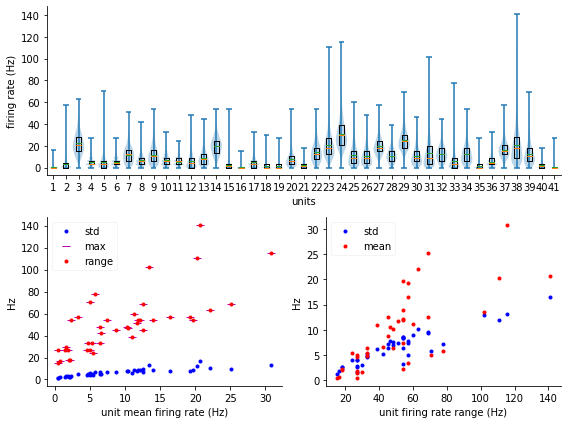

In [12]:
spike_rate = units_fr.spike_rate
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.violinplot(spike_rate.values, widths=.9)
plt.boxplot(spike_rate.values, widths=0.4, whis=(0, 100),
            showmeans=True, meanline=True, showfliers=False, showcaps=False,
            meanprops={'linestyle': '-'}, whiskerprops={'color':'none'})
plt.xlabel('units')
plt.ylabel('firing rate (Hz)')

plt.subplot(2, 2, 3)
plt.plot(units_fr.units_fr_mean, units_fr.units_fr_std, 'b.', label='std')
plt.plot(units_fr.units_fr_mean, units_fr.units_fr_max, 'm.', marker='_', markersize=8, label='max')
plt.plot(units_fr.units_fr_mean, units_fr.units_fr_range, 'r.', label='range')
plt.xlabel('unit mean firing rate (Hz)')
plt.ylabel('Hz')
plt.legend(loc='upper left', framealpha=0.2)
plt.subplot(2, 2, 4)
plt.plot(units_fr.units_fr_range, units_fr.units_fr_std, 'b.', label='std')
plt.plot(units_fr.units_fr_range, units_fr.units_fr_mean, 'r.', label='mean')
plt.xlabel('unit firing rate range (Hz)')
plt.ylabel('Hz')
plt.legend(loc='upper left', framealpha=0.2)

plt.tight_layout()
plt.show()

### Preprocess units firing rate

Enter parameters:


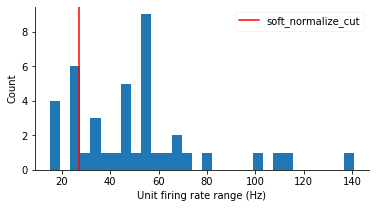

In [13]:
sigma = 0.02 # sec
normalization_scale = 'range' # 'range', 'std', 'mean'
quantile = 0.2
sigma, normalization_scale, quantile = get_parameters({
        'fr_smooth_sigma': sigma,
        'fr_normalization_scale': normalization_scale,
        'fr_normalize_quantile': quantile
    }, preprocess_dict, False)

redo = True
while redo:
    sigma, normalization_scale, quantile = get_parameters({
        'fr_smooth_sigma': sigma,
        'fr_normalization_scale': normalization_scale,
        'fr_normalize_quantile': quantile
    }, parameters_dict, enter_parameters)
    norm_scale = getattr(units_fr, 'units_fr_' + normalization_scale)
    soft_normalize_cut = np.quantile(norm_scale, quantile)
    plt.figure(figsize=(6, 3))
    plt.hist(norm_scale, bins=30)
    plt.axvline(soft_normalize_cut, color='r', label='soft_normalize_cut')
    plt.xlabel(f'Unit firing rate {normalization_scale:s} (Hz)')
    plt.ylabel('Count')
    plt.legend(loc='upper right', framealpha=0.2)
    plt.show()

    redo = whether_redo()

In [14]:
for stim in stimulus_names:
    units_spk_counts[stim] = preprocess_firing_rate(units_spk_counts[stim].assign(fr_stats), sigma,
        soft_normalize_cut=soft_normalize_cut, normalization_scale=norm_scale)
    units_frs[stim] = preprocess_firing_rate(units_frs[stim].assign(fr_stats), sigma,
        soft_normalize_cut=soft_normalize_cut, normalization_scale=norm_scale)

## Get natural movies LFP and power

In [15]:
channel_id = info['center_unit_channel_id']
channel_group_map = pd.read_csv(filepath.replace('.nc', '.csv'), index_col='id')
unit_channel = pd.Series(channel_group_map.loc[sel_units['peak_channel_id'], 'group_id'].values,
                         index=sel_units_id, name='channel_group_id')
group_id = channel_group_map.loc[channel_id, 'group_id']
# group_id = unit_channel.mode().item()

print(f"Channel group: {group_id:d}")

Channel group: 4


In [16]:
extend_time = 0.5  # extend time window for filter edge effect
beta_band = [20., 40.]
gamma_band = [40., 70.]
extend_time, beta_band, gamma_band = get_parameters({
        'extend_time': extend_time,
        'beta_band': beta_band,
        'gamma_band': gamma_band
    }, parameters_dict, enter_parameters)

freq_band = dict(beta=beta_band, gamma=gamma_band)
waves = list(freq_band)
n_waves = len(waves)
colors = {'beta': 'b', 'gamma': 'r'}

filt_sigma = int(bin_width * lfp_array.fs)

Enter parameters:


In [17]:
lfp_filts = {}
for stim in stimulus_names:
    lfp_filt_file = filepath_prefix(stim) + '_lfp_filt_power.nc'
    if os.path.isfile(lfp_filt_file):
        lfp_filt = xr.load_dataset(lfp_filt_file)
        overwrite = not np.all([np.allclose(lfp_filt.filt_band.sel(wave=w), freq_band[w]) for w in waves])
    else:
        overwrite = True
    if overwrite:
        _, presentations_ids, presentations_times, trial_duration = align_movie(
            session.stimulus_presentations, stimulus_name=stim)
        aligned_lfp = align_trials(lfp_array, presentations_ids, presentations_times, window=(0. - extend_time, trial_duration + extend_time))
        aligned_lfp = aligned_lfp.sel(channel=group_id).assign_attrs(extend_time=extend_time)
        lfp_filt = {}
        for w in waves:
            filt_ds = bandpass_lfp(aligned_lfp, freq_band[w], output='sos')
            # calculate power from amplitude (convert to uV)
            lfp_power = (filt_ds.amplitude * 1e6) ** 2 / 2
            lfp_power_total = 1e12 * gauss_filt_da(aligned_lfp.LFP ** 2, filt_sigma, dim='time_from_presentation_onset')
            lfp_power_normalized = lfp_power / lfp_power_total  # normalize by sqrt of power
            filt_ds = filt_ds.assign(
                lfp_power=lfp_power,
                lfp_power_total=lfp_power_total,
                lfp_power_normalized=lfp_power_normalized,
            )
            lfp_filt[w] = filt_ds
        lfp_filt = xr.concat(lfp_filt.values(), dim=pd.Index(waves, name='wave'))
        # downsample to spike time histogram sampling rate
        t = units_spk_counts[stim].time_relative_to_stimulus_onset.values
        wins = t[:, None] + units_spk_counts[stim].bin_width / 2 * np.array([-1, 1])
        ds_wins = []
        for win in wins:
            ds_wins.append(lfp_filt.sel(time_from_presentation_onset=slice(*win)).mean(dim='time_from_presentation_onset'))
        del lfp_filt.attrs['filt_band']
        lfp_filt = xr.concat(ds_wins, dim=pd.Index(t, name='time_from_presentation_onset')).assign_attrs(**lfp_filt.attrs)
        lfp_filt = lfp_filt.assign(filt_band=xr.DataArray([freq_band[w] for w in waves],
            coords=dict(wave=lfp_filt.wave, cutoff=['lower', 'upper'])))
        lfp_filt.to_netcdf(lfp_filt_file)
    lfp_filts[stim] = lfp_filt

#### Check power distribution

In [18]:
# for stim, lfp_filt in lfp_filts.items():
#     print(stim)
#     t = lfp_filt.time_from_presentation_onset
#     for var in ['lfp_power', 'lfp_power_normalized']:
#         print(var)
#         power = lfp_filt[var]
#         pow_mean = []
#         _, axs = plt.subplots(2, 1, figsize=(15, 5))
#         for ax, w in zip(axs, waves):
#             x = power.sel(wave=w)
#             x_mean = x.mean(dim='presentation_id')
#             pow_mean.append(x_mean.values.ravel())
#             x_std = x.std(dim='presentation_id')
#             ax.plot(t, x_mean, color=colors[w], label=w)
#             ax.fill_between(t, x_mean - x_std, x_mean + x_std, facecolor=colors[w], edgecolor='none', alpha=0.1)
#             ax.set_xlim(t[0], t[-1])
#             ax.set_xlabel('Time (sec)')
#             ax.set_ylabel('power')
#             ax.legend(loc='upper right')
#         plt.tight_layout()

#         plt.figure(figsize=(6, 5))
#         pow = [power.sel(wave=w).values.ravel() for w in waves[:2]]
#         plt.plot(*pow, '.', color='gray', markersize=1, alpha=0.2, label='all trials')
#         plt.plot(*pow_mean, '.', color='k', markersize=2, alpha=0.5, label='trial averaged')
#         plt.xlabel(waves[0])
#         plt.ylabel(waves[1])
#         plt.legend(loc='upper right')
#         plt.show()

## PCA analysis

In [19]:
normalize_unit_fr = True
normalize_power = True

normalize_unit_fr, normalize_power = get_parameters({
        'normalize_unit_fr': normalize_unit_fr,
        'normalize_power': normalize_power
    }, parameters_dict, enter_parameters)

unit_fr_var = 'normalized' if normalize_unit_fr else 'smoothed'
power_metric = 'Normalized LFP power' if normalize_power else 'LFP power'

Enter parameters:


Explained variance % of top 10 components: 
15.98, 10.86, 7.98, 5.20, 4.98, 4.25, 3.87, 3.24, 3.07, 2.72


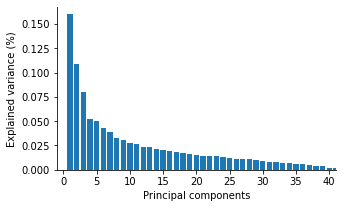

In [20]:
from sklearn.decomposition import PCA

average_trials = True
units_vec = stimuli_data_to_samples((units_frs if average_trials else units_spk_counts).values(),
                                   average_trials=average_trials, var=unit_fr_var)

n_units = units_vec.unit_id.size
n_components = n_units
pca = PCA(n_components=n_components)
pca.fit(units_vec)

print('Explained variance % of top 10 components: \n' + 
      ', '.join('%.2f' % (100 * x) for x in pca.explained_variance_ratio_[:10]))
plt.figure(figsize=(5, 3))
plt.bar(np.arange(n_components) + 1, pca.explained_variance_ratio_)
plt.xlim(-1, min(n_components, 50))
plt.xlabel('Principal components')
plt.ylabel('Explained variance (%)')
fig_disp(f'Movies_PC_explained_variance_{unit_fr_var:s}')

In [21]:
pop_vecs = {}
for stim, spk_counts in units_spk_counts.items():
    pop_vec = stack_time_samples(spk_counts[unit_fr_var], average_trials=False)
    pop_vec = pop_vec.copy(data=pca.transform(pop_vec)).rename(unit_id='PC').unstack('sample')
    pop_vec.coords['PC'] = range(n_components)
    pop_vecs[stim] = pop_vec

### Population trajectories and relation with wave power

#### Calculate total mean firing rate

In [22]:
mean_tot_frs = {}  # mean total (normalized) firing rate of all units
rms_frs = {}  # root mean square firing rate of all units
for stim, spk_counts in units_spk_counts.items():
    frs = spk_counts[unit_fr_var].isel(time_relative_to_stimulus_onset=slice(1, None))
    mean_tot_frs[stim] = frs.mean(dim='unit_id')
    rms_frs[stim] = (frs ** 2).mean(dim='unit_id') ** 0.5

#### Settings and choosing LFP waves power metric

In [23]:
combine_stimuli = True  # whether combine stimuli (two movies) for some analyses

PC_disp = list(range(2))  # first 2 PCs for display
cmap = 'jet'


if power_metric == 'LFP power':
    # filtered power
    waves_power = {stim: power.lfp_power for stim, power in lfp_filts.items()}
elif power_metric == 'Normalized LFP power':
    # filtered power normalized by total power
    waves_power = {stim: power.lfp_power_normalized for stim, power in lfp_filts.items()}
for stim, power in waves_power.items():
    waves_power[stim] = power.rename(presentation_id='stimulus_presentation_id',
                                     time_from_presentation_onset='time_relative_to_stimulus_onset')

sample_dims = ('stimulus_presentation_id', 'time_relative_to_stimulus_onset')
pc_dims = ('PC', 'sample')

Enter parameters:
Stimulus 'natural_movies': Magnitude of population change x Mean normalized firing rate


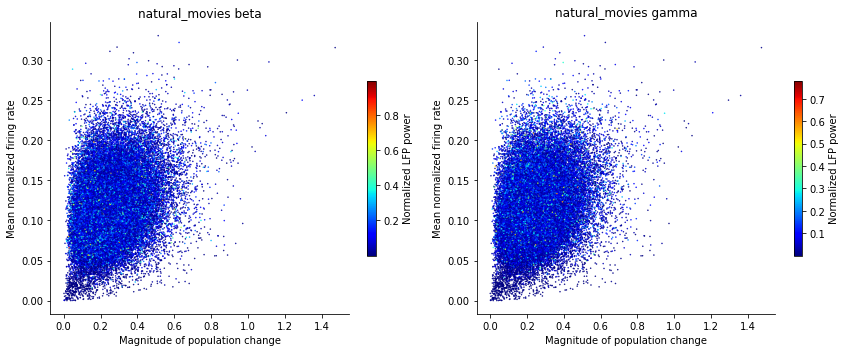

Stimulus 'natural_movies': Heatmap of power


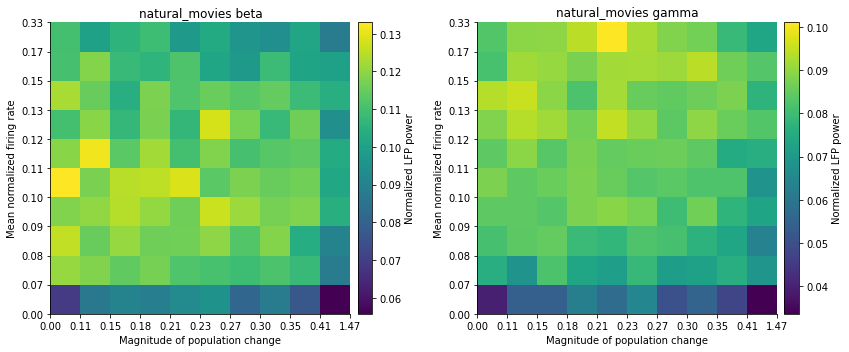

In [24]:
figsize = (6, 5)
even_grid = True

# Choose data for heatmap
x_data = 'speed'  # 'speed', 'ang', 'tangent'
y_data = 'mean_fr'  # 'mean_fr', 'rms_fr', 'length', 'radial'
n_main_pc = 3
absolute_origin = True
n_bins = 10

redo = True
while redo:
    x_data, y_data, n_main_pc, absolute_origin, n_bins = get_parameters({
            'x_data': x_data,
            'y_data': y_data,
            'n_main_pc': n_main_pc,
            'absolute_origin': absolute_origin,
            'n_bins': n_bins,
        }, parameters_dict, enter_parameters)

    # Calculate velocity and angle
    PC_main = list(range(n_main_pc))

    if absolute_origin:
        pop_vec_org = pca.transform(np.zeros([1, n_units]))[0]
    else:
        pop_vec_org = np.zeros(n_units)
    pop_vec_org = xr.DataArray(pop_vec_org, coords=dict(PC=range(n_components)))

    pop_vels = {}  # velocity
    pop_speeds = {}  # speed along main PCs
    pop_angs = {}  # angle changed along main PCs
    pop_lengths = {}  # length of population vector along main PCs
    pop_radials = {}  # radial speed
    pop_tangents = {}  # tangent speed
    for stim, pop_vec in pop_vecs.items():
        pop_vec = (pop_vec - pop_vec_org).sel(PC=PC_main)  # consider only main PCs
        pop_vec_len = (pop_vec ** 2).sum(dim='PC') ** 0.5
        pop_vec0 = pop_vec.isel(time_relative_to_stimulus_onset=slice(1, None))
        pop_vec1 = pop_vec.isel(time_relative_to_stimulus_onset=slice(None, -1))
        pop_vec0_len = pop_vec_len.isel(time_relative_to_stimulus_onset=slice(1, None))
        pop_vec1_len = pop_vec_len.isel(time_relative_to_stimulus_onset=slice(None, -1))
        # velocity
        pop_vel = pop_vec0.copy(data=pop_vec0.values - pop_vec1.values)
        pop_vels[stim] = pop_vel
        # speed
        pop_speeds[stim] = speed = (pop_vel ** 2).sum(dim='PC') ** 0.5
        # angle
        pc_axis = pop_vec.dims.index('PC')
        dot = np.sum(pop_vec0.values * pop_vec1.values, axis=pc_axis)
        pop_angs[stim] = speed.copy(data=np.degrees(np.arccos(dot / (pop_vec0_len.values * pop_vec1_len.values))))
        # radial/tangent speed
        pop_lengths[stim] = pop_vec0_len
        unit_vec0 = pop_vec0 / pop_vec0_len
        radial_vel = np.sum(unit_vec0.values * pop_vel.values, axis=pc_axis)
        pop_radials[stim] = radial_vel = pop_vec0_len.copy(data=radial_vel)
        tangent_vel = pop_vel - radial_vel * unit_vec0
        pop_tangents[stim] = (tangent_vel ** 2).sum(dim='PC') ** 0.5

    # Differentiate population vectors
    data_dict = dict(
        mean_fr = dict(data=mean_tot_frs, label=f'Mean {unit_fr_var:s} firing rate', fmt='{:.2f}'),
        rms_fr = dict(data=rms_frs, label=f'RMS {unit_fr_var:s} firing rate', fmt='{:.2f}'),
        ang = dict(data=pop_angs, label='Angle of population change (degree)', fmt='{:.0f}'),
        speed = dict(data=pop_speeds, label='Magnitude of population change', fmt='{:.2f}'),
        length = dict(data=pop_lengths, label='Magnitude of population vector', fmt='{:.2f}'),
        radial = dict(data=pop_radials, label='Magnitude of population radial change', fmt='{:.2f}'),
        tangent = dict(data=pop_tangents, label='Magnitude of population tangent change', fmt='{:.2f}')
    )
    attrs = {key: xr.DataArray([da[key] for da in data_dict.values()],
        coords={'data': list(data_dict)}) for key in ['label', 'fmt']}
    if combine_stimuli:
        power_data = {combine_stimulus_name: stimuli_data_to_samples(
            [power.isel(time_relative_to_stimulus_onset=slice(1, None)) \
                for power in waves_power.values()], sample_dims=sample_dims)}
        vel_data = {combine_stimulus_name: stimuli_data_to_samples(
            pop_vels.values(), average_trials=False).transpose(*pc_dims)}
        for data in data_dict.values():
            data['data'] = {combine_stimulus_name: stimuli_data_to_samples(
                data['data'].values(), average_trials=False)}
    else:
        power_data = {stim: stack_time_samples(
            power.isel(time_relative_to_stimulus_onset=slice(1, None)), sample_dims=sample_dims) \
                for stim, power in waves_power.items()}
        vel_data = {stim: stack_time_samples(pop_vel, average_trials=False).transpose(*pc_dims) \
                for stim, pop_vel in pop_vels.items()}
        for data in data_dict.values():
            data['data'] = {stim: stack_time_samples(da, average_trials=False) \
                for stim, da in data['data'].items()}
    power_ds = {}
    for stim, da in power_data.items():
        fname = f"{stim:s}_power_heatmap_{unit_fr_var:s}_fr"
        ds = da.to_dataset(name='power').assign_attrs(stimulus=stim)
        ds = ds.assign(**{name: da['data'][stim] for name, da in data_dict.items()}, **attrs)
        ds = ds.dropna(dim='sample')
        power_ds[fname] = ds.assign_coords(sample=np.arange(ds.sample.size))

    # Plots
    for ds in power_ds.values():
        stim = ds.attrs['stimulus']
        labels = ds.label.sel(data=[x_data, y_data]).values
        print(f"Stimulus '{stim:s}': {labels[0]:s} x {labels[1]:s}")
        _, axs = plt.subplots(1, n_waves, figsize=(n_waves * figsize[0], figsize[1]))
        for ax, w in zip(axs, waves):
            sc = ax.scatter(ds[x_data], ds[y_data], c=ds.power.sel(wave=w), s=1, marker='.', cmap=cmap)
            plt.colorbar(mappable=sc, ax=ax, label=power_metric, shrink=0.6)
            ax.autoscale_view()
            ax.set_xlabel(labels[0])
            ax.set_ylabel(labels[1])
            ax.set_title(f'{stim:s} {w:s}')
        plt.tight_layout()
        plt.show()

    for fname, ds in power_ds.items():
        stim = ds.attrs['stimulus']
        print(f"Stimulus '{stim:s}': Heatmap of power")
        # get quantile grids and average power in grids
        power = ds.power.transpose('wave', 'sample').values
        power_avg, (x_bins, y_bins), hist_count = statistic_in_quantile_grid(
            [ds[x_data], ds[y_data]], power, n_bins=n_bins)
        power_avg = np.swapaxes(power_avg, -1, -2)  # transpose x, y axis
        # plot heatmap
        labels = ds.label.sel(data=[x_data, y_data]).values
        fmts = ds.fmt.sel(data=[x_data, y_data]).values
        fig, axs = plt.subplots(1, n_waves, figsize=(n_waves * figsize[0], figsize[1]))
        for i, w in enumerate(power_data[stim].wave.values):
            ax = axs[i]
            pcm = heatmap_in_grid(power_avg[i], x_bins, y_bins,
                xticks_fmt=fmts[0], yticks_fmt=fmts[1], even_grid=even_grid, ax=ax)
            plt.colorbar(mappable=pcm, ax=ax, label=power_metric, pad=0.02)
            ax.set_xlabel(labels[0])
            ax.set_ylabel(labels[1])
            ax.set_title(f'{stim:s} {w:s}')
        plt.tight_layout()
        fig_disp({fname + f"_{x_data:s}_{y_data:s}": fig})

    redo = whether_redo()

In [25]:
# Save heatmap data
for fname, ds in power_ds.items():
    ds.to_netcdf(filepath_prefix(fname) + '.nc')

#### Trajectories

In [26]:
# # magnitude of velocity along each main PC
# vel_pc_data = {}
# for pc in PC_main:
#     vel_pc = {stim: pop_vel.sel(PC=pc) for stim, pop_vel in vel_data.items()}
#     vel_pc = dict(data=vel_pc, label=f'PC {pc:d} change', fmt='{:.2f}')
#     vel_pc_data[pc] = vel_pc

Average trajectory


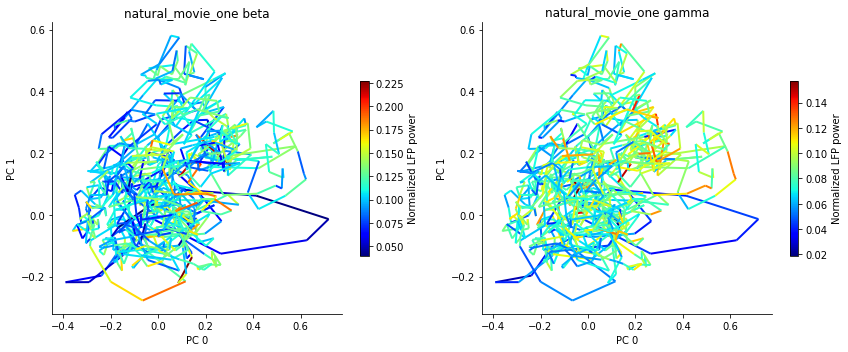

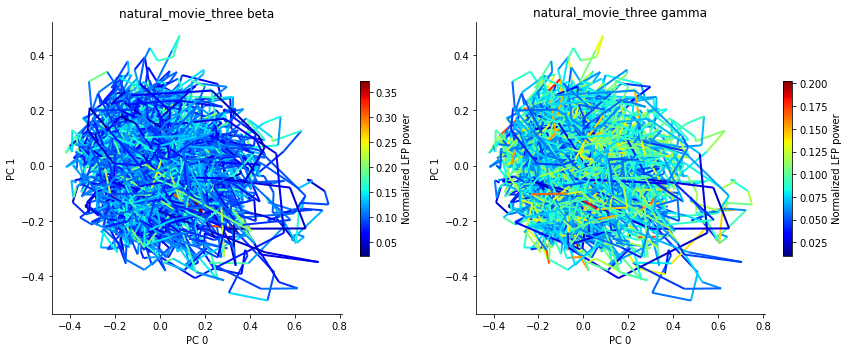

In [27]:
print('Average trajectory')
for stim, pop_vec in pop_vecs.items():
    pop_vec_avg = pop_vec.sel(PC=PC_disp).transpose('PC', *sample_dims).mean(dim='stimulus_presentation_id')
    power = waves_power[stim].mean(dim='stimulus_presentation_id')
    _, axs = plt.subplots(1, n_waves, figsize=(n_waves * figsize[0], figsize[1]))
    for ax, w in zip(axs, waves):
        line = plot_multicolor_line(*pop_vec_avg, c=power.sel(wave=w)[1:], ax=ax, cmap=cmap)
        plt.colorbar(mappable=line, ax=ax, label=power_metric, shrink=0.6)
        ax.autoscale_view()
        ax.set_xlabel(f'PC {PC_disp[0]:d}')
        ax.set_ylabel(f'PC {PC_disp[1]:d}')
        ax.set_title(f'{stim:s} {w:s}')
    plt.tight_layout()
plt.show()

#### Population vectors

All trials population vector


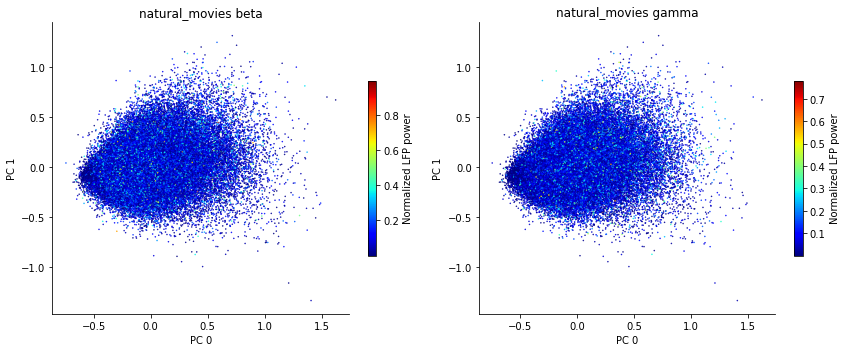

In [28]:
print('All trials population vector')

if combine_stimuli:
    data = {combine_stimulus_name: stimuli_data_to_samples(
        [pop_vec.sel(PC=PC_disp) for pop_vec in pop_vecs.values()],
        average_trials=False).transpose(*pc_dims)}
    power_data = {combine_stimulus_name: stimuli_data_to_samples(
        waves_power.values(), sample_dims=sample_dims)}
else:
    data = {stim: stack_time_samples(
        pop_vec.sel(PC=PC_disp), average_trials=False).transpose(*pc_dims) \
            for stim, pop_vec in pop_vecs.items()}
    power_data = {stim: stack_time_samples(power, sample_dims=sample_dims) \
            for stim, power in waves_power.items()}

for stim, pop_vec in data.items():
    power = power_data[stim]
    _, axs = plt.subplots(1, n_waves, figsize=(n_waves * figsize[0], figsize[1]))
    for ax, w in zip(axs, waves):
        sc = ax.scatter(*pop_vec, c=power.sel(wave=w), s=1, marker='.', cmap=cmap)
        plt.colorbar(mappable=sc, ax=ax, label=power_metric, shrink=0.6)
        ax.autoscale_view()
        ax.set_xlabel(f'PC {PC_disp[0]:d}')
        ax.set_ylabel(f'PC {PC_disp[1]:d}')
        ax.set_title(f'{stim:s} {w:s}')
    plt.tight_layout()
plt.show()

## Save parameters in config

In [29]:
with open(info_file, 'w') as f:
    json.dump(info, f, indent=4)